### This notebook will walk you through how to build a lipid bilayer with OpenFF

In [1]:
# Import all dependencies 
# from io import StringIO
# from typing import Iterable
import numpy as np
# import matplotlib.pyplot as plt

# from rdkit import Chem
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from openff.toolkit import ForceField, Molecule, Topology
# from openff.toolkit.utils.toolkits import OpenEyeToolkitWrapper

from openff.units import Quantity, unit
# from openmm import unit as openmm_unit
from openff.interchange import Interchange
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper #assign charges with NAGL

import nglview
import mdtraj
import sys
import os
import shutil
from pathlib import Path

scripts_path = os.path.join(os.getcwd(), 'scripts')
sys.path.insert(0, scripts_path)

from pull import pullLipid
import BuildLipid
from saveLipids import saveInterchange, Lipid, calcLipidLength, saveLipidCsv
from packmol import _build_input_file, runPackmol

/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/Bio/__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: /home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages
  warnings.warn(


### Build lipid and water from smiles string and use OpenFF Interchange to parameterize

Available lipids are located in BuildLipid module, which constructs lipids in a modular fashion {sn1} + {hg} + {sn2}.

In [2]:
# load in openFF's library of lipids and return a list of availablee lipid headgroups,tailgroups, and sterols to choose from
df = BuildLipid.load_dataframe()
BuildLipid.list_available_lipids(df) 

Available headgroups:  ['PA', 'PC', 'PE', 'PG', 'PP', 'PS']
Available tailgroups:  ['DC', 'DD', 'DL', 'DM', 'DO', 'DP', 'DR', 'DS', 'PE', 'PL', 'PO', 'PS', 'SL', 'SO']
Available sterols:  ['aldosterone', 'beta-Sitosterol', 'beta-estradiol', 'cholesterol', 'corticosterone', 'cortisol', 'ergosterol', 'estradiol', 'progesterone', 'stigmasterol', 'testosterone']


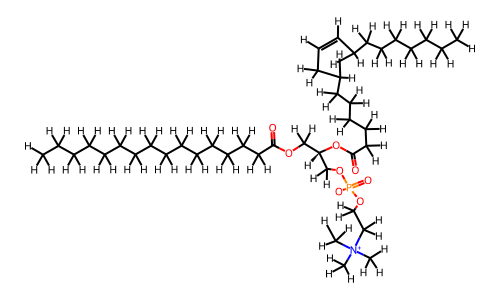

In [3]:
# Specify lipid you would like to parameterize "headgroup+tailgroup" or "sterol" (ex. 'POPC' or 'cholesterol') from the library of lipids
Lipid_name = 'POPC'
lipid_smiles, HG_pull_atom = BuildLipid.makeLipidSmiles(Lipid_name, df)


# if you want a lipid that is not yet supplied by the library, uncomment the 3 lines below and replace smiles string with your desired lipid,
# the pull atom with an atom in the headgroup, and the Lipid name with the common name or the lipid

# lipid_smiles = 'CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)CCCCCCC/C=C\CCCCCCCC'
# HG_pull_atom = 'N1x' #note that atom naming is openff format: atom type + atom number + x
# Lipid_name = 'POPC'


lipid = Molecule.from_smiles(lipid_smiles)
lipid.generate_conformers()
lipid.visualize()

In [6]:
# Assign partial charges via OpenFF NAGL
lipid.assign_partial_charges("openff-gnn-am1bcc-0.1.0-rc.2.pt", toolkit_registry=NAGLToolkitWrapper())
lipid.partial_charges


lipid.name = Lipid_name
for i, atom in enumerate(lipid.atoms, 0):
    atom.metadata["residue_name"] = Lipid_name
lipid.generate_unique_atom_names() 
topology = Topology.from_molecules([lipid])

# Specify forcefield
forcefield = ForceField("openff-2.1.0.offxml")

interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
    charge_from_molecules = [lipid]
)
interchange  

interchange.to_top(f"{Lipid_name}.top") #, decimal = 3, hydrogen_mass = 3) #for hygrogen mass repartitioning.. probably need another topology file filder for HMR
# or is there from grompp option to change topology file that can be used downstream?
interchange.to_gro(f"{Lipid_name}.gro")

/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/interchange/interop/gromacs/export/_export.py:48: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  self._write_gro(gro, decimal)


In [7]:
water_model = 'TIP3P'
water = Molecule.from_smiles('O')
water.generate_conformers()
water.name = water_model

for i, atom in enumerate(water.atoms, 3):
    atom.metadata["residue_name"] = water_model
water.generate_unique_atom_names() 
topology = Topology.from_molecules([water])


interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
)
interchange

# PDB structure for Packmol
interchange.to_pdb(f"{water_model}.pdb")

In [ ]:
pullLipid(f'{Lipid_name}',f'{Lipid_name}.gro', f'{Lipid_name}.top', HG_pull_atom)

In [ ]:
# save the pulled lipid pdb to folder, creates a folder for specific lipid if it doesnt already exist
file_paths = [f'{Lipid_name}.pdb', f'{Lipid_name}.top'] 
saveInterchange(Lipid_name, file_paths)


### Use trjconv to produce a pdb of the lipid after pull code. Visualize with nglview to confirm 


In [ ]:
#visualize the pulled lipid using ngl view
view = nglview.show_structure_file(f'Dictionary/lipids_parameterized/{Lipid_name}/{Lipid_name}.pdb')
view


In [ ]:
# save the pulled lipid data to a csv. YOU WILL NEED TO MANUALLY FIND AN ATOM IN THE LIPID TAIL
lipid = Lipid(
    name=Lipid_name,
    headgroup_atom=HG_pull_atom,  
    headgroup_atom_index=None, 
    tailgroup_atom='C42x',  # this needs to be changed for every simulation
    tailgroup_atom_index=None,
    distance=None,  
    experimental_density=None  # Example value in g/cm^3
)

# Calculate lipid length
calcLipidLength(lipid, Lipid_name)

# Save the lipid to the CSV file
saveLipidCsv(lipid)

In [4]:
number_of_lipids = 128
number_of_solvent = 2560*2

packmol_file_name, output_file_path, dims = _build_input_file(Lipid_name, number_of_lipids, 'TIP3P',number_of_solvent,2, 'PulledLipid.csv' )


In [5]:
# A packmol_input.inp file has been created in the main directory
# To run: 


#consider adding runPackmol into _build_input_file (but first make sure it runs for all lipids)
runPackmol(packmol_file_name)



################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 20.14.2 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Types of coordinate files specified: pdb
  Seed for random number generator:      1234567
  Output file: packmol_output.pdb
  Reading coordinate file: POPC.pdb
  Reading coordinate file: POPC.pdb
  Reading coordinate file: TIP3P.pdb
  Reading coordinate file: TIP3P.pdb
  Number of independent structures:            4
  The structures are: 
  Structure            1 :POPC.pdb(         134  atoms)
  Structure            2 :POPC.pdb(         134  atoms)
  Structure            

In [ ]:
view = nglview.show_structure_file(output_file_path)
view

### Build topology file from system interchange and get .gro file from .pdb

In [9]:
topology = Topology.from_molecules(number_of_lipids * [lipid]+ number_of_solvent * [water])

# Packmol bilayer to parametrize
path = mdtraj.load(output_file_path)
topology.set_positions(path.xyz[0] * unit.nanometer)
topology.box_vectors =  np.array(dims)*0.1 * unit.nanometer #convert from angstoms (packmol default) to openff default nm

interchange = forcefield.create_interchange(topology)

interchange.to_gromacs(prefix = "bilayer")

In [ ]:
# Do you want to add ions?

# gmx grompp -f ions.mdp -c bilayer.gro -p topol.top -o ions.tpr
# gmx genion -s ions.tpr -o bilayer_ions.gro -p topol.top -pname NA -nname CL -neutral\

# When prompted, choose group TIP3P (group 2) for embedding ions. You do not want to replace parts of your protein with ions

In [ ]:
# $ gmx grompp -f min.mdp -p topol.top -c bilayer.gro -o min.tpr
# $ gmx mdrun -deffnm min

# $ gmx grompp -p topol.top -f nvt.mdp -c min.gro -o nvt.tpr
# $ gmx mdrun -deffnm nvt

# $ gmx grompp -f npt.mdp -p topol.top -c nvt.gro -o npt.tpr -maxwarn 1
# $ gmx mdrun -deffnm npt

# $ gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr
# $ gmx mdrun -deffnm md
# # Checkpoint run for completion
# $ gmx mdrun -deffnm md -cpi md.cpt